## Focus Algo Testing

In [1]:
import sys
sys.path.insert(0, '../../source')
sys.path.insert(0, '../../source/miq')
sys.path.append('C:\\Program Files\\Micro-Manager-2.0beta')

import MMCorePy
import miq
import sc_utils as utils
import focus
import position as pos
from matplotlib import pyplot as plt
import os
import time
import numpy as np
import scipy.interpolate

mmc = MMCorePy.CMMCore()
mmc.loadSystemConfiguration("../../../config/scope_stage.cfg")
mmc.setFocusDevice("FocusDrive")
print ("Devices loaded from config file:\n", mmc.getLoadedDevices())
print ("\n Stage at: (", mmc.getXPosition(), ",", mmc.getYPosition(), ")")

focus_model = miq.get_classifier()

Devices loaded from config file:
 ('COM5', 'COM4', 'Scope', 'FocusDrive', 'XYStage', 'Core')

 Stage at: ( -0.0 , -0.0 )
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model.ckpt-1000042


### Manually Focus chip at positions:

Move to and focus 4 random points

In [25]:
x1 = mmc.getXPosition()
y1 = mmc.getYPosition()
z1_manual = mmc.getPosition()
print (x1,',', y1,',', z1_manual)

-12373.4 , 2204.9 , 358014737062.8512


In [26]:
x2 = mmc.getXPosition()
y2 = mmc.getYPosition()
z2_manual = mmc.getPosition()
print (x2,',', y2,',', z2_manual)

-4790.3 , 5003.3 , 358014737044.3908


In [27]:
x3 = mmc.getXPosition()
y3 = mmc.getYPosition()
z3_manual = mmc.getPosition()
print (x3,',', y3,',', z3_manual)

2651.4 , -252.1 , 358014737009.3928


In [28]:
x4 = mmc.getXPosition()
y4 = mmc.getYPosition()
z4_manual = mmc.getPosition()
print (x4,',', y4,',', z4_manual)

-12745.5 , -1424.4 , 358014737061.2172


In [29]:
# Save the positons 
pos_list_xy = pos.PositionList()
manual_poslist = pos.PositionList()
for x,y,z in [(x1,y1, z1_manual),(x2,y2, z2_manual),(x3,y3, z3_manual),(x4,y4, z4_manual)]:
    sp = pos.StagePosition(x=x, y=y)
    pos_list_xy.append(sp)
    sp_man = pos.StagePosition(x=x, y=y, z=z)
    manual_poslist.append(sp_man)
pos_list_xy.save("xy_pos", os.getcwd())
manual_poslist.save("manual_focus", os.getcwd())

In [2]:
# Load previously saved positions
pos_list_xy = pos.load('xy_pos', os.getcwd())
manual_poslist = pos.load('manual_focus', os.getcwd())

# Test Focus from image stack method

This method takes a stack of images at a specific point and finds the focus predition of each image in the stack. Then, adds the z height with the smallest prediction to the position list. 



In [30]:
total_z = 100
delta_z = 5
xy_points = pos_list_xy

In [34]:
start_time = time.time()

# Get focus model
focus_model = miq.get_classifier()

pos_list = pos.PositionList()

# make z position array
cur_pos = mmc.getPosition()
start_pos = cur_pos + total_z/2
end_pos = cur_pos - total_z/2
num_steps = (start_pos-end_pos) / delta_z
print (start_pos, end_pos, num_steps)
z = np.linspace(start_pos, end_pos, num_steps)

cam = utils.start_cam()
point_preds = []

for posit in xy_points:
    # Go to the x,y position 
    print (posit.x, posit.y)
    pos.set_pos(mmc, posit.x, posit.y)

    preds = []
    for curr_z in z:
        mmc.setPosition(curr_z)
        mmc.waitForSystem()
        frame = cam.get_frame(exp_time=1).reshape(cam.sensor_size[::-1])
        preds.append(focus_model.score(frame))
    # find the index of the min focus prediction
    best_focus_index = np.argmin(preds)
    # append to the PositionList 
    sp = pos.StagePosition(x=posit.x, y=posit.y,
                           z=z[best_focus_index])
    pos_list.append(sp)
    point_preds.append(preds)

utils.close_cam(cam)

total_time = time.time() - start_time
print ("Total Time for", len(xy_points), "points:", total_time)

INFO:tensorflow:Restoring parameters from model.ckpt-1000042
358014737034.9322 358014736934.9322 20.0


/home/cellcounter/miniconda2/envs/Py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


-12373.4 2204.9
-4790.3 5003.3
2651.4 -252.1
-12745.5 -1424.4
Total Time for 4 points: 157.10771870613098


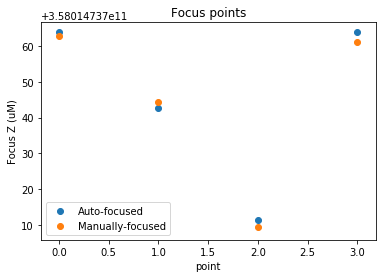

In [32]:
x = [0,1,2,3]
y_auto = []
y_manual = []
for p in pos_list:
    y_auto.append(p.z)
for p in manual_poslist:
    y_manual.append(p.z)

plt.scatter(x, y_auto, label='Auto-focused')
plt.scatter(x, y_manual, label='Manually-focused')
plt.title('Focus points')
plt.xlabel('point')
plt.ylabel('Focus Z (uM)')
plt.legend()

# Test Curve fitting

In [63]:
def guassian(x,a,b,c,d):
    return (a*np.exp(-(np.square(x-b))/(2*np.square(c)))) + d

def p3(x,a,b,c,d):
    return (a+(x*b)+np.square(x*c)+np.power(x*d, 3))

def p4(x,a,b,c,d,e):
    return (a+(x*b)+np.square(x*c)+np.power(x*d, 3)+np.power(x*e, 4))

In [96]:
z_loc = mmc.getPosition()
prediction = []
cam = utils.start_cam()
for i in range (80):
    mmc.setPosition(z_loc - (2.5*i))
    mmc.waitForSystem()
    frame = cam.get_frame(exp_time=1).reshape(cam.sensor_size[::-1])
    prediction.append(focus_model.score(frame))
utils.close_cam(cam)

Text(0, 0.5, 'Focus Prediction')

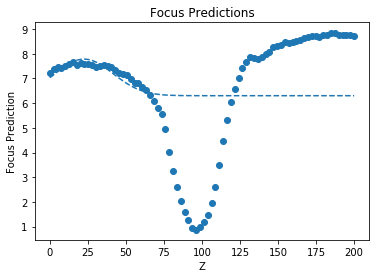

In [74]:
from scipy.optimize import curve_fit
# Fit the gaussian to the prediction data 
x= np.linspace(0, 200, 80)
popt, pcov = curve_fit(guassian, x, prediction)

plt.scatter(x, prediction)
plt.plot(x,guassian(x, *popt), '--')

plt.title('Focus Predictions')
plt.xlabel('Z')
plt.ylabel('Focus Prediction')

### Fitting using a defined function did not work, so I am using an interp function to get a good fit of the data. 

In [97]:
f=scipy.interpolate.interp1d(x, prediction, kind='cubic')

Text(0, 0.5, 'Focus Prediction')

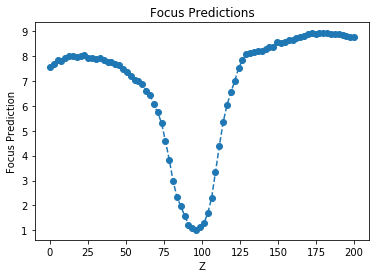

In [98]:
plt.scatter(x, prediction)
plt.plot(x,f(x), '--')

plt.title('Focus Predictions')
plt.xlabel('Z')
plt.ylabel('Focus Prediction')

Now lets see if multiple positions on the chip follow the same pattern

In [99]:
# Position #2
z_loc = mmc.getPosition()
prediction2 = []
cam = utils.start_cam()
for i in range (80):
    mmc.setPosition(z_loc - (2.5*i))
    mmc.waitForSystem()
    frame = cam.get_frame(exp_time=1).reshape(cam.sensor_size[::-1])
    prediction2.append(focus_model.score(frame))
utils.close_cam(cam)

In [100]:
# Position #3
z_loc = mmc.getPosition()
prediction3 = []
cam = utils.start_cam()
for i in range (80):
    mmc.setPosition(z_loc - (2.5*i))
    mmc.waitForSystem()
    frame = cam.get_frame(exp_time=1).reshape(cam.sensor_size[::-1])
    prediction3.append(focus_model.score(frame))
utils.close_cam(cam)

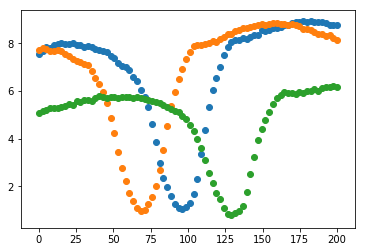

In [101]:
plt.scatter(x, prediction)
plt.scatter(x, prediction2)
plt.scatter(x, prediction3)

### The Blue and Orange Positions are interior chip poins, while the green is along the egde of the chip. 

In [82]:
cam = utils.start_cam()
z1 = mmc.getPosition()
frame = cam.get_frame(exp_time=1).reshape(cam.sensor_size[::-1])
pred1 = focus_model.score(frame)
print (z1, pred1)

358014737009.123 3.7428572132870777


In [83]:
z2 = mmc.getPosition()
frame = cam.get_frame(exp_time=1).reshape(cam.sensor_size[::-1])
pred2 = focus_model.score(frame)
utils.close_cam(cam)
print (z2, pred2)

358014736994.7742 7.484355020197346


# Test Using Last Point

First point -> basic z stack prediction -> pick best point 
Next point -> start @ (last best focus - 30 um) -> move in +z dir and break when two predictions in a row have been worse than the previous ones. Need to snake


In [ ]:
start_time = time.time()

# Get focus model
focus_model = miq.get_classifier()

pos_list = pos.PositionList()

# make z position array
cur_pos = mmc.getPosition()
start_pos = cur_pos + total_z/2
end_pos = cur_pos - total_z/2
num_steps = (start_pos-end_pos) / delta_z
z = np.linspace(start_pos, end_pos, num_steps)

cam = utils.start_cam()

for posit in xy_points:
    # Go to the x,y position 
    pos.set_pos(mmc, posit.x, posit.y)

    preds = []
    heights = []
    for curr_z in z:
        mmc.setPosition(curr_z)
        mmc.waitForSystem()
        frame = cam.get_frame(exp_time=1).reshape(cam.sensor_size[::-1])
        preds.append(focus_model.score(frame))
        heights.append(curr_z)
        index = len(preds) - 1
        if index > 2:
            if (preds[index] > preds [index-1] and 
                preds[index] > preds [index-2]):
                break
    # find the index of the min focus prediction
    best_focus_index = np.argmin(preds)
    # append to the PositionList 
    sp = pos.StagePosition(x=posit.x, y=posit.y,
                           z=heights[best_focus_index])
    print (sp)
    pos_list.append(sp)

utils.close_cam(cam)
total_time = time.time() - start_time
print ('Completed focus in', total_time, 'seconds')

In [4]:
test = True

In [6]:
test = not test

In [7]:
test

False